In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
city = '서울'

path = 'Data/Variants/Infected/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files[city]
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,162.0,42.12,3.24
1,2021-04-13,158.0,41.08,3.16
2,2021-04-14,247.0,64.22,4.94
3,2021-04-15,217.0,56.42,4.34
4,2021-04-16,216.0,56.16,4.32
...,...,...,...,...
121,2021-08-11,660.0,6.60,627.00
122,2021-08-12,526.0,5.26,499.70
123,2021-08-13,524.0,5.24,497.80
124,2021-08-14,513.0,5.13,487.35


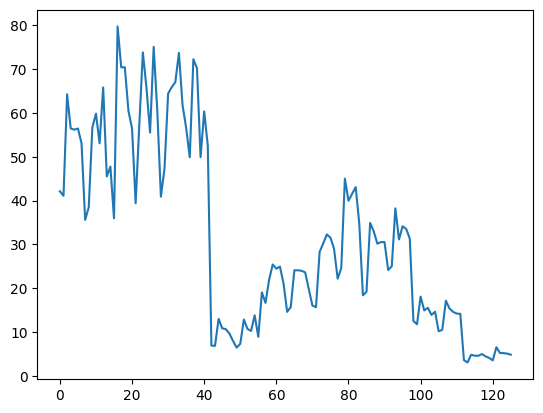

In [3]:
plt.plot(data['alpha_variants'])

In [4]:
cities = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

dic_hyperparameter = {}
for city in cities:
    path = f'hyperparameter/Infected/alpha/{city}/*.pkl'
    files = glob.glob(path)
    hyperparameter = {}
    for file in files:
        hyperparameter[file[33:-4]] = load_hyperparameter(file)

    dic_hyperparameter[city] = hyperparameter

In [17]:
city_predicted = {}

for city in cities:
    
    dic_model = load_model_multiple(dic_hyperparameter, 'Infected', 'alpha', city)
    data = dic_files[city]
    df = Prepare_df.processing(data, 'stdDay', 'alpha_variants')

    x = df.iloc[:, 0:]
    y = df.iloc[:,:1]

    ms = MinMaxScaler()
    ss = StandardScaler()

    ss.fit(x)
    ms.fit(y)

    predicted_values = {}
    num_model = 0
    for name, state in dic_model.items():
        batch_size = 64
        if num_model < 6:
            x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 57, 60, 1, batch_size, 'mto')
            label_y, predicted = predict_mto(state, df, x_ss, y_ms)
            predicted_values[name] = [label_y, predicted]
        else:
            x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 51, 60, 7, batch_size, 'mtm')
            label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
            predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]

        num_model += 1
        
    city_predicted[city] = predicted_values

In [18]:
dic_best_model = {}

for city in cities:
    
    actual_data = city_predicted[city]['RNN'][0]
    rmse_min = np.inf
    num_model = 0

    for name, file in city_predicted[city].items():
        if num_model < 6:
            predicted_data = file[1]
        else:
            predicted_data = file[4]

        rmse_val = rmse(actual_data[-7:], predicted_data[-7:])
        if rmse_min > rmse_val:
            rmse_min = rmse_val
            best_model = name
            best_actual = actual_data
            best_predicted = predicted_data

        #print(city + ' :', rmse_val)
        #plotting(actual_data, predicted_data, 56)

        num_model += 1
    
    dic_best_model[city] = [best_model, rmse_val, best_actual, best_predicted]
    
    print(f'rmse가 가장 적은 모델 : {city}', best_model)
    df_predicted = pd.DataFrame()
    df_predicted = pd.DataFrame(np.concatenate([best_actual, best_predicted], axis = 1), columns = ['Alpha_origin', 'Alpha_Predicted'])
    df_predicted.index = list(data['stdDay'][-1*len(best_actual):])
    df_predicted.to_csv(f'Data/Predicted/Variants/Infected/{city}/alpha_{best_model}.csv')

rmse가 가장 적은 모델 : 강원 LSTM
rmse가 가장 적은 모델 : 경기 BiLSTM
rmse가 가장 적은 모델 : 경남 RNN
rmse가 가장 적은 모델 : 경북 BiLSTM
rmse가 가장 적은 모델 : 광주 LSTM
rmse가 가장 적은 모델 : 대구 seq2seq_BiLSTM
rmse가 가장 적은 모델 : 대전 seq2seq_LSTM
rmse가 가장 적은 모델 : 부산 BiRNN
rmse가 가장 적은 모델 : 서울 BiLSTM
rmse가 가장 적은 모델 : 세종 seq2seq_GRU
rmse가 가장 적은 모델 : 울산 seq2seq_BiRNN
rmse가 가장 적은 모델 : 인천 BiLSTM
rmse가 가장 적은 모델 : 전남 BiGRU
rmse가 가장 적은 모델 : 전북 seq2seq_BiLSTM
rmse가 가장 적은 모델 : 제주 LSTM
rmse가 가장 적은 모델 : 충남 LSTM
rmse가 가장 적은 모델 : 충북 BiGRU


In [33]:
city_predicted['대구']['seq2seq_RNN'][4].shape

(64, 1)

In [50]:
city = '대구'
actual_data = city_predicted[city]['RNN'][0]
num_model = 0
for name, file in city_predicted[city].items():
    if num_model < 6:
        predicted_data = file[1]
    else:
        predicted_data = file[4]
    num_model += 1
    df = pd.DataFrame()
    df = pd.DataFrame(np.concatenate([actual_data.reshape(-1, 1), predicted_data.reshape(-1, 1)], axis = 1), columns = ['Alpha_origin', 'Alpha_Predicted'])
    df.index = list(data['stdDay'][-1*len(actual_data):])
    df_predicted.to_csv(f'Data/JH/{city}_alpha_{best_model}.csv')

In [46]:
df

,Alpha_origin,Alpha_Predicted
2021-06-13,1.80,2.345562
2021-06-14,2.40,2.307758
2021-06-15,1.92,2.154855
2021-06-16,1.92,1.927045
2021-06-17,0.84,1.732720
...,...,...
2021-08-11,0.66,0.886684
2021-08-12,0.39,0.776954
2021-08-13,0.57,0.680753
2021-08-14,0.82,0.615758


강원 best model : LSTM
rmse : 0.9560493570399313


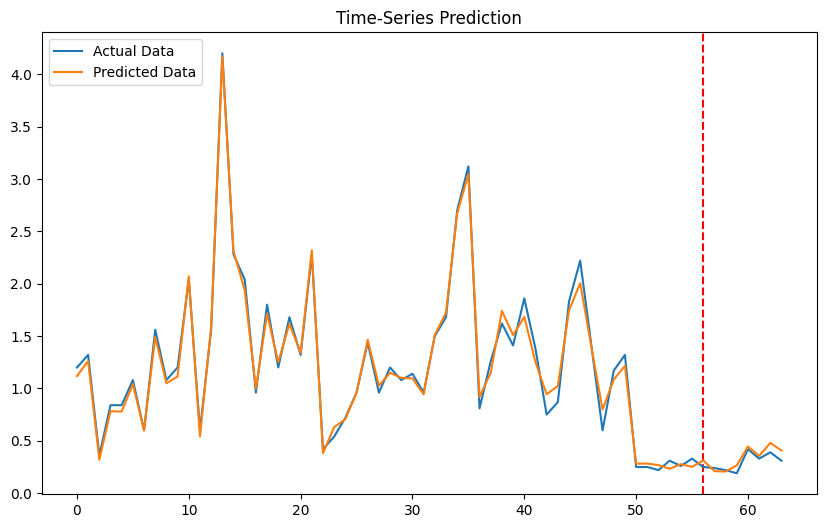

경기 best model : BiLSTM
rmse : 1.8459541594123439


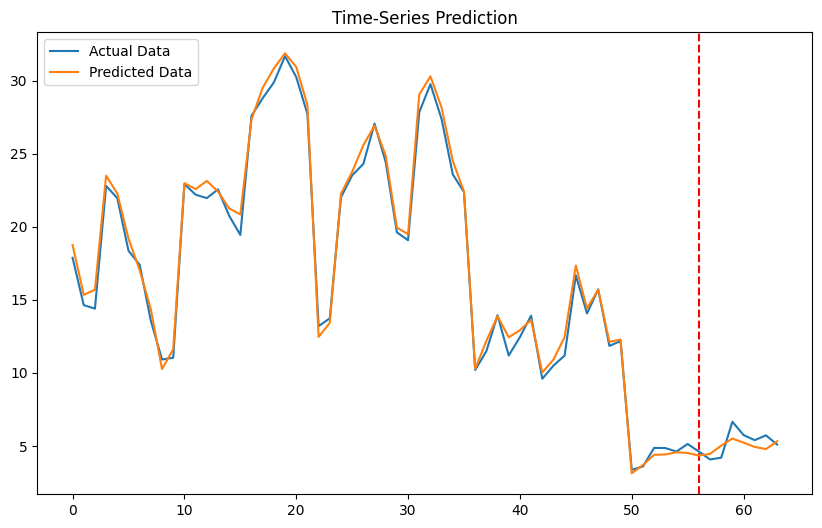

경남 best model : RNN
rmse : 0.7432754974431316


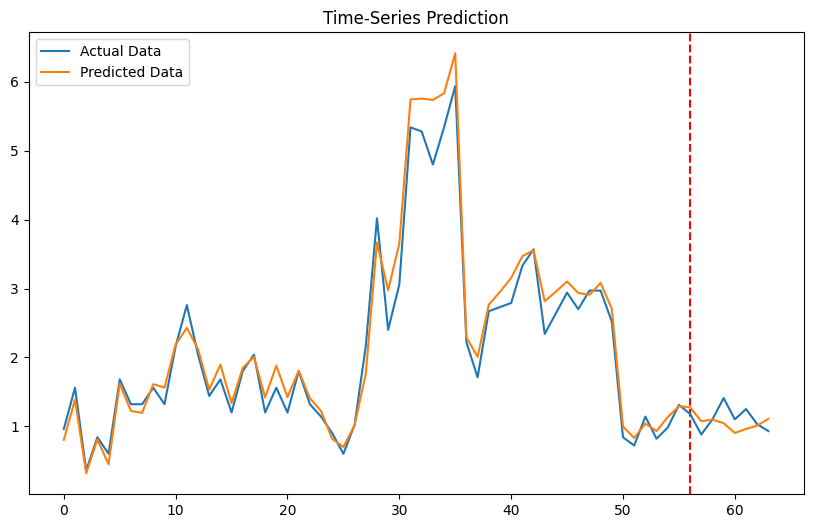

경북 best model : BiLSTM
rmse : 0.1621103114365337


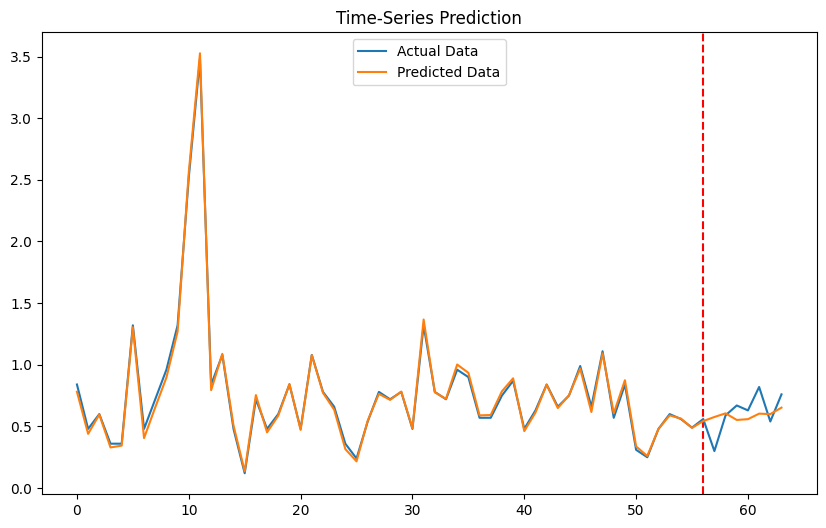

광주 best model : LSTM
rmse : 0.2564665019337828


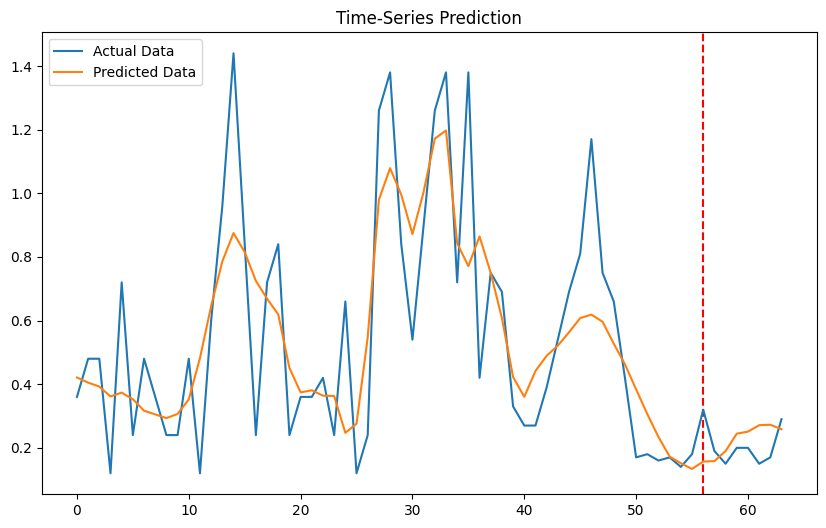

대구 best model : seq2seq_BiLSTM
rmse : 0.20001213252997735


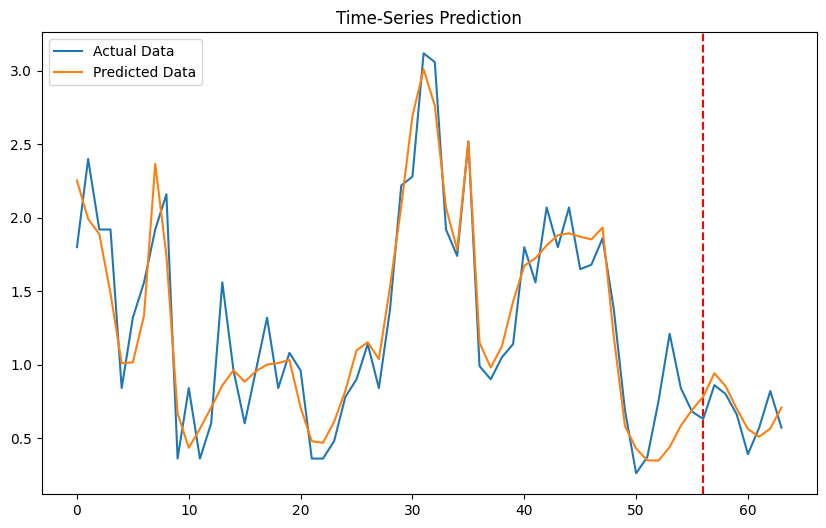

대전 best model : seq2seq_LSTM
rmse : 1.424307952949932


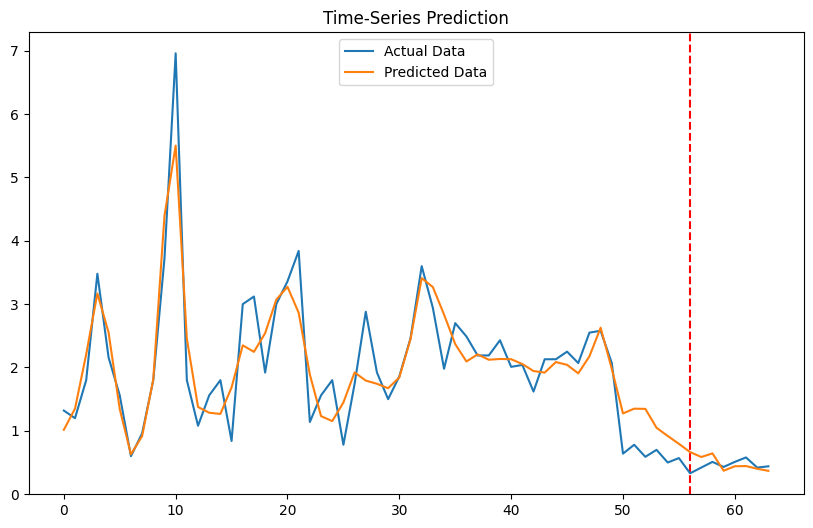

부산 best model : BiRNN
rmse : 0.37114131020398516


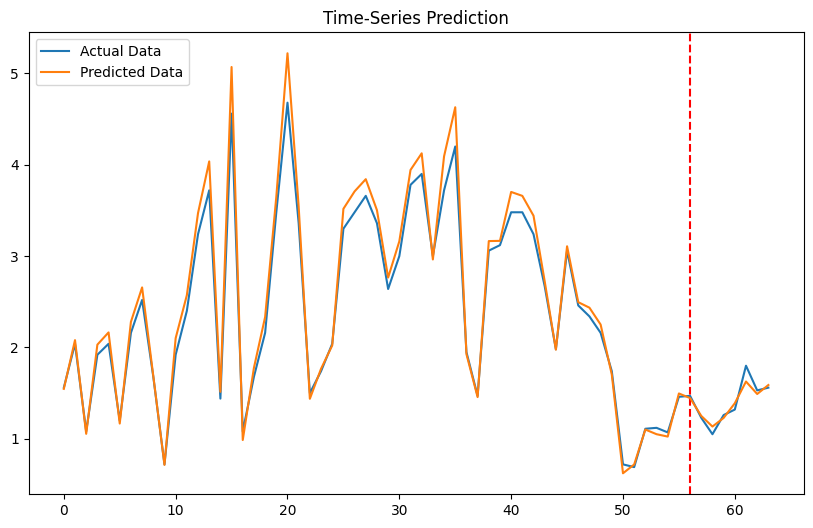

서울 best model : BiLSTM
rmse : 2.541356291867706


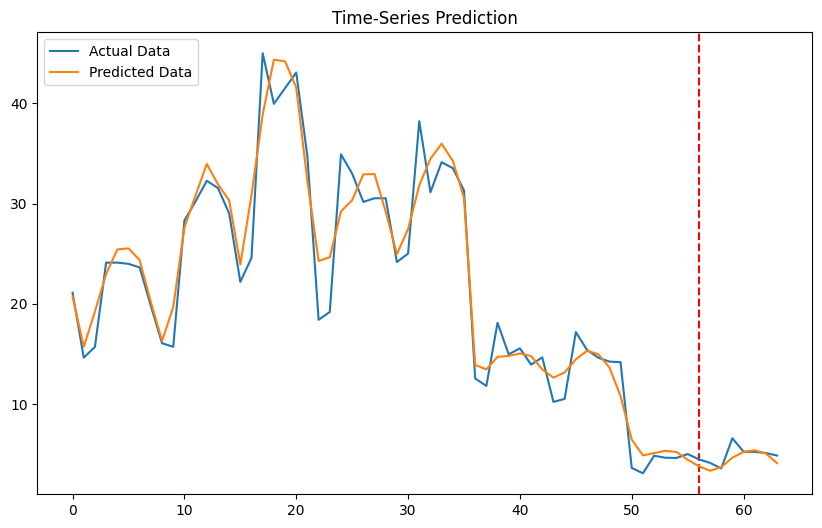

세종 best model : seq2seq_GRU
rmse : 0.11950586959557274


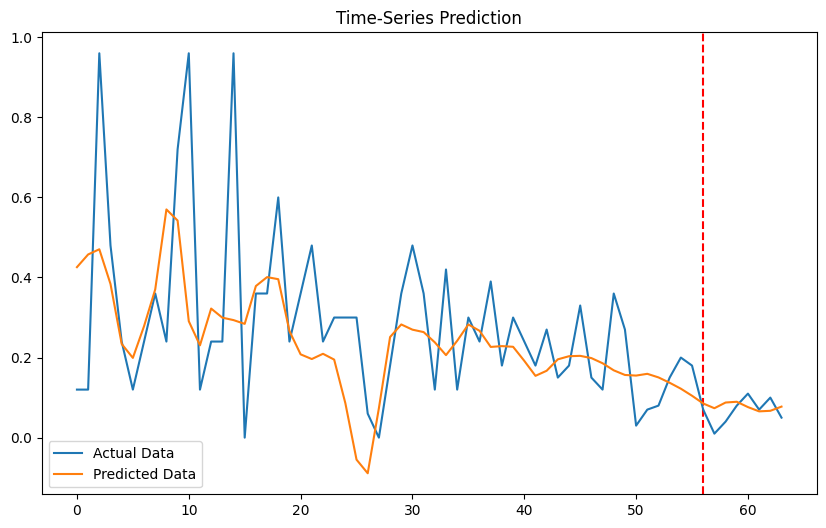

울산 best model : seq2seq_BiRNN
rmse : 0.19022369981457524


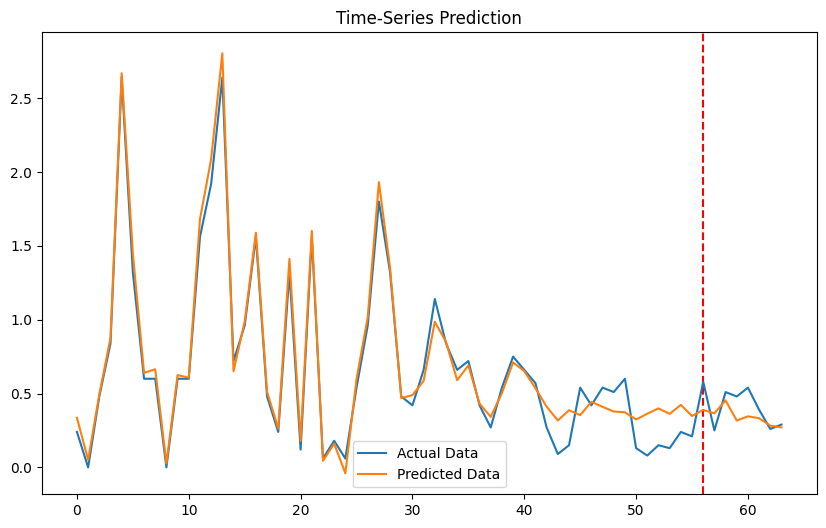

인천 best model : BiLSTM
rmse : 0.36489483151020186


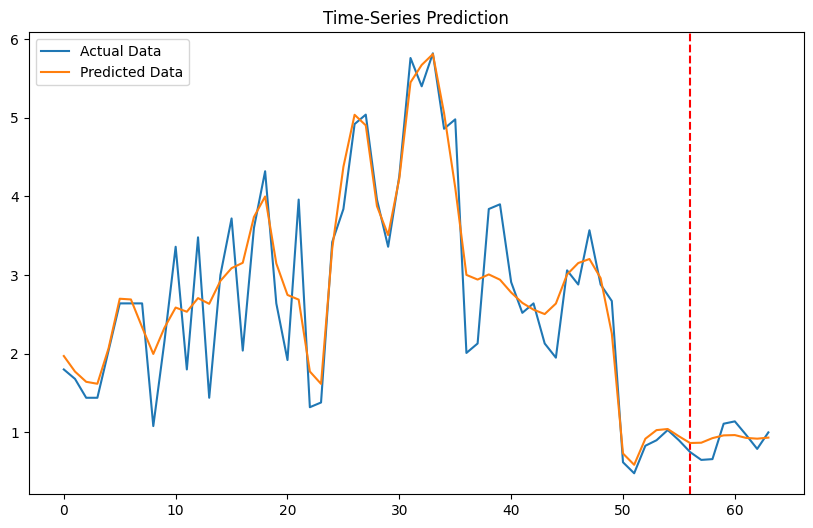

전남 best model : BiGRU
rmse : 0.1735011787188998


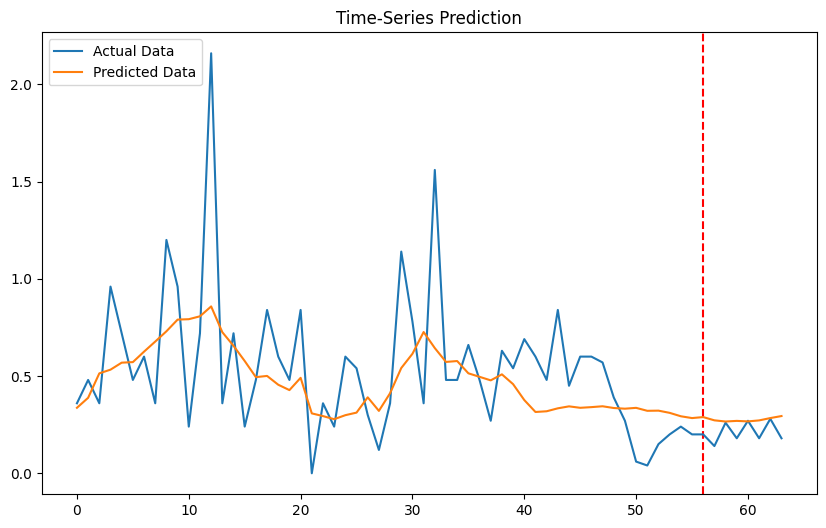

전북 best model : seq2seq_BiLSTM
rmse : 0.24791259585305467


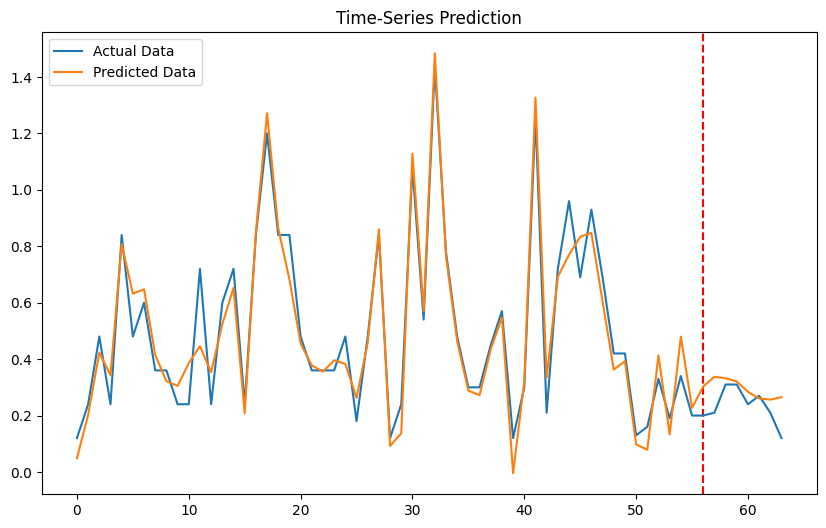

제주 best model : LSTM
rmse : 0.11902064786195228


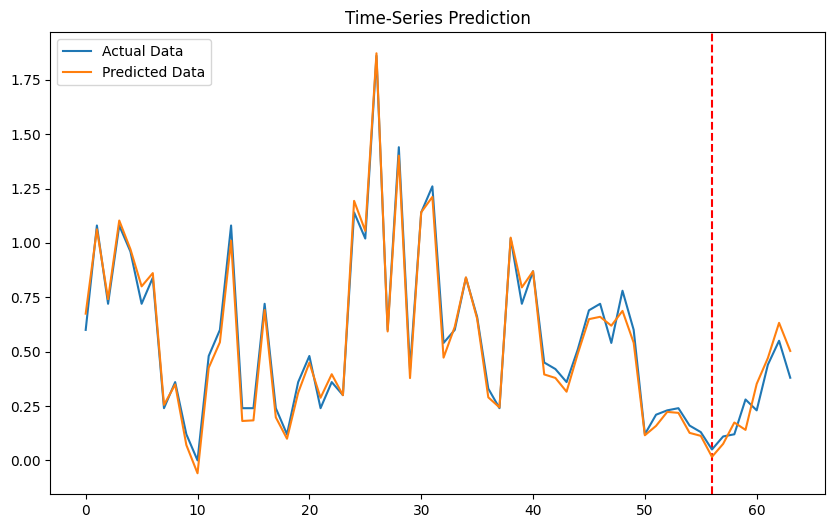

충남 best model : LSTM
rmse : 0.15549680250681297


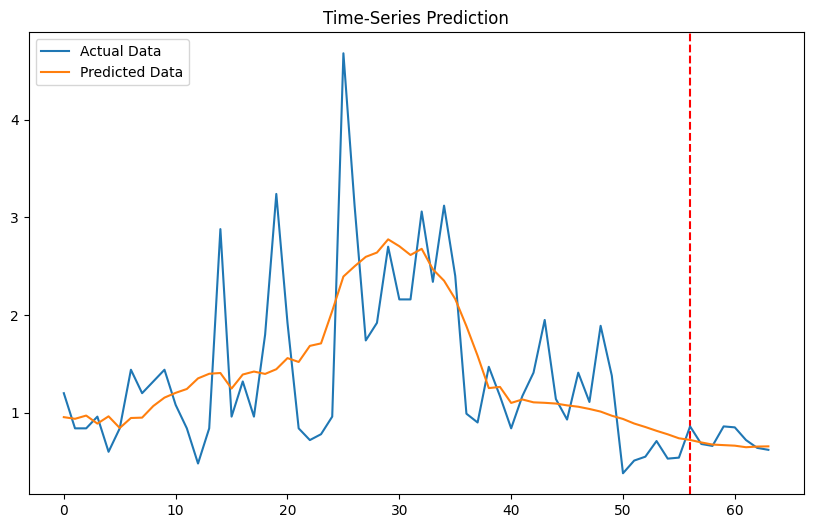

충북 best model : BiGRU
rmse : 0.1270498714077249


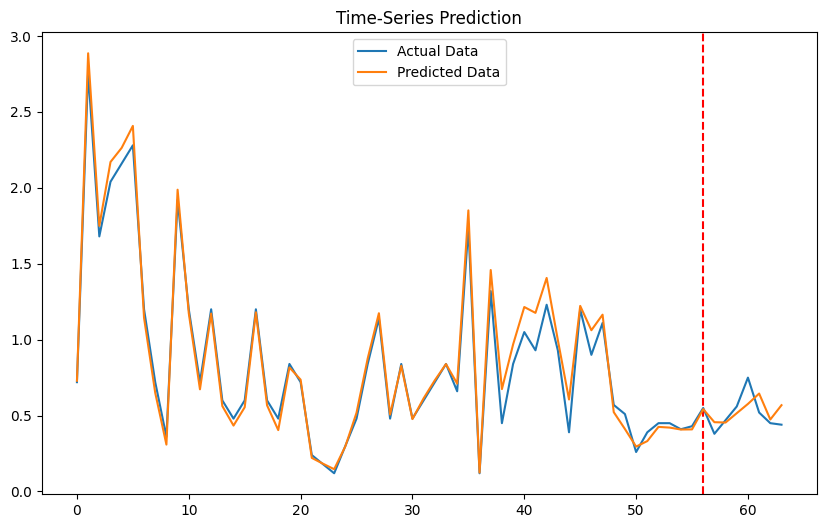

In [27]:
for city in cities:
    print(f'{city} best model : {dic_best_model[city][0]}')
    print(f'rmse : {dic_best_model[city][1]}')
    plotting(dic_best_model[city][2], dic_best_model[city][3], 56)